In [690]:
import numpy as np
import albumentations as A
from albumentations import DualTransform
import albumentations.pytorch.transforms as AT
from PIL import Image
import IPython
import imageio
import cv2 
import matplotlib.pyplot as plt 

def vis_points(image, points, diameter=1):
    im = image.copy()
    for (x, y) in points:
        cv2.circle(im, (int(x), int(y)), diameter, (0, 255, 0), -1)
    plt.figure()
    plt.imshow(im)
    
    
class CustomTransform(DualTransform):
    """Transform for segmentation task."""
    
    def __init__(self, padding=[20,20,20,20], always_apply=False, p=1.0):
        super(CustomTransform, self).__init__(always_apply, p)
        self.padding = padding
        
    @property
    def targets(self):
        return {
            "image": self.apply,
            "mask": self.apply_to_mask,
            "masks": self.apply_to_masks,
            "bboxes": self.apply_to_bboxes,
            "keypoints": self.apply_to_keypoints,
        }

    def apply(self, image, **params):
        padding = self.padding
        if padding[0]>0:
            image[:,:padding[0],:] = 0
        if padding[1]>0:
            image[:padding[1],:,:] = 0
        if padding[2]>0:
            image[:, -padding[2]:,:] = 0
        if padding[3]>0:
            image[-padding[3]:,:,:] = 0
            
        return image
        
    def apply_to_bbox(self, bbox, **params):
        raise NotImplementedError("Method apply_to_bbox is not implemented in class " + self.__class__.__name__)

    def apply_to_keypoint(self, keypoint, **params):
        padding = self.padding
        print("AP", params)
        x,y = keypoint[:2]
        if x < padding[0]:
            return (-1,-1,-1,-1)
        if x > params['cols']-padding[2]:
            return (-1,-1,-1,-1)
        if y < padding[1]:
            return (-1,-1,-1,-1)
        if y > params['rows']-padding[3]:
            return (-1,-1,-1,-1)
        return keypoint

    def apply_to_bboxes(self, bboxes, **params):
        return [self.apply_to_bbox(tuple(bbox[:4]), **params) + tuple(bbox[4:]) for bbox in bboxes]

    def apply_to_keypoints(self, keypoints, **params):
        return [self.apply_to_keypoint(tuple(keypoint[:4]), **params) + tuple(keypoint[4:]) for keypoint in keypoints]

    def apply_to_mask(self, img, **params):
        return self.apply(img, **{k: cv2.INTER_NEAREST if k == "interpolation" else v for k, v in params.items()})

    def apply_to_masks(self, masks, **params):
        return [self.apply_to_mask(mask, **params) for mask in masks]
    

0 1 [0 1]
{'image': <bound method RandomGridShuffle.apply of RandomGridShuffle(always_apply=False, p=1.0, grid=(3, 3))>, 'mask': <bound method RandomGridShuffle.apply_to_mask of RandomGridShuffle(always_apply=False, p=1.0, grid=(3, 3))>, 'masks': <bound method DualTransform.apply_to_masks of RandomGridShuffle(always_apply=False, p=1.0, grid=(3, 3))>, 'bboxes': <bound method DualTransform.apply_to_bboxes of RandomGridShuffle(always_apply=False, p=1.0, grid=(3, 3))>, 'keypoints': <bound method DualTransform.apply_to_keypoints of RandomGridShuffle(always_apply=False, p=1.0, grid=(3, 3))>}
0 1 [0 1]


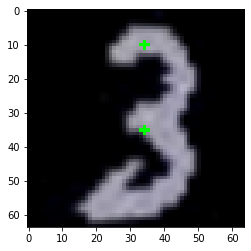

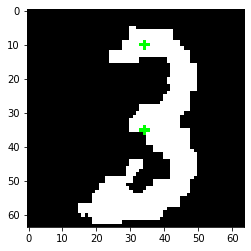

In [747]:
image_path = '/Users/daniele/work/workspace_python/cookiecutter_test/persefone/tests/sample_data/datasets/minimnist/000007_image.jpg'
mask_path = '/Users/daniele/work/workspace_python/cookiecutter_test/persefone/tests/sample_data/datasets/minimnist/000007_image_mask.png'
points_path = '/Users/daniele/work/workspace_python/cookiecutter_test/persefone/tests/sample_data/datasets/minimnist/000007_points.txt'
image = imageio.imread(image_path)
mask = (imageio.imread(mask_path).astype(float) /255. ).astype(np.uint8)
points = np.loadtxt(points_path).reshape((-1,2))

print(mask.min(), mask.max(),np.unique(mask))
#print(points)
#vis_points(image, points)

r = A.Resize(height=64,width=64,p=1)
rot = A.Rotate(limit=(-90,90),p=1)
#aff = A.IAAPiecewiseAffine(p=1.0)
aff = A.IAAPerspective(p=1.0)
br = A.RandomBrightnessContrast(p=1.0)
gig = A.RandomGridShuffle(p=1.0)
print(gig.targets)
my = CustomTransform(padding=[50,20,50,10],always_apply=True, p=0.0)
#rot = A.RandomRotate90(p=1)
T = A.Compose([r,br,aff],p=1, keypoint_params=A.KeypointParams(format='xy'))



points = [(14,5),(14,25),(14,14)]
results = T(image=image, mask=mask, keypoints=points)
#results['mask'][results['mask']>0] = 255
print(results['mask'].min(), results['mask'].max(), np.unique(results['mask']))
vis_points(results['image'],results['keypoints'], diameter=1)
vis_points(results['mask']*255,results['keypoints'], diameter=1)
#vis_points(mask,pts, diameter=1)
#IPython.display.display(Image.fromarray(image))
#tt = AT.ToTensor()
#tensor = tt(image=image)['image']
#print(tensor.shape, tensor.min(), tensor.max())

IPython.display.display(Image.fromarray(image))

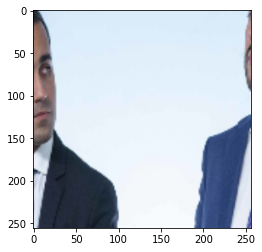

In [734]:
image_path = '/Users/daniele/Downloads/Salvini-Di-Maio_botte-sì-crisi-no.jpg'
image = imageio.imread(image_path)

r = A.Resize(height=256,width=256,p=1)
c = A.Crop(50,50,200,200,always_apply=True)
#my = CustomTransform(padding=[50,20,50,10],always_apply=True, p=0.0)
#rot = A.RandomRotate90(p=1)
T = A.Compose([r,c,r],p=1, keypoint_params=A.KeypointParams(format='xy'))

image = T(image=image,mask=None, keypoints=[])['image']

vis_points(image, [])